In [1]:
import pandas as pd
import numpy as np
import folium
from sklearn.cluster import KMeans
from math import *
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from random import *
# warning messages no print
import warnings
warnings.filterwarnings("ignore")

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### 데이터 로드, longitude 태평양중심

In [2]:
data = pd.read_csv('D:/SDS_project/data/1205_data.csv')
data['LON'] = data['LON'].apply(lambda x : (x - 360) if x>0 else x )

### MMSI3 그룹화해서 개수 보기

In [ ]:
# data.groupby('MMSI3').count()['MMSI'].head()

### MMSI3 기준으로 배가 몇개인지 확인

In [ ]:
# len(data.groupby('MMSI3').count())

###### 배 경로 시각화(간단 코드)

In [ ]:
data1 = data[data['MMSI3']=='636092379_83_3']
data1 = data1.reset_index()
m = folium.Map(location=[data1.loc[0,'LAT'], data1.loc[0,'LON']], zoom_start=1)
for i in range(data1.shape[0]):
    folium.CircleMarker(location=[data1.loc[i,'LAT'], data1.loc[i,'LON']], color = 'red', radius = 0.05).add_to(m)
m

### 도착지점에 대하여...(가장 많은 도착지점은 어떤 항구인가?)

##### 항구가져오기

In [3]:
port = pd.read_csv('D:/SDS_project/data/DATA/PORT_MERGE_out.csv')

In [4]:
df1 = data.groupby('MMSI3').last()
L2 = []
for i,j,k in zip(df1.index, df1['LAT'], df1['LON']):
    L1 = []
    for l1, l2 in zip(port['LAT'], port['LON']):
        R = 6373.0 
        lat1 = radians(j) 
        lon1 = radians(k) 
        lat2 = radians(l1) 
        lon2 = radians(l2) 
        dlon = lon2 - lon1 
        dlat = lat2 - lat1 
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2 
        c = 2 * atan2(sqrt(a), sqrt(1 - a)) 
        distance = R * c
        L1.append(distance)
    L2.append([min(L1), port.iloc[L1.index(min(L1)),0], port.iloc[L1.index(min(L1)),1], port.iloc[L1.index(min(L1)),2]])

##### 2828개의 ship, 옆에 LAT, LON 붙이기

In [5]:
port_count = pd.DataFrame(L2, columns = ['distance', 'port_id', 'LAT', 'LON']).reset_index(drop=True).groupby('port_id').agg({'distance':'count', 'LAT':'mean', 'LON':'mean'}).reset_index().sort_values(by='distance', ascending=False)
df2 = port_count[port_count.port_id.isin(['USOAK', 'USLGB', 'KRPUS', 'JPSHS', 'MXZLO', 'CNYTN'])].reset_index(drop=False)
# df2

### 도착지(어떤 항구)를 기준으로 5km이내 모든 경로 가져오기

In [6]:
def port_5km(data, lat, lon):
    data1 = data.groupby(['MMSI3']).last()
    L1 = []
    
    for i,j,k in zip(data1.index, data1['LAT'], data1['LON']):
        R = 6373.0 
        lat1 = radians(j) 
        lon1 = radians(k) 
        lat2 = radians(lat) 
        lon2 = radians(lon)
        dlon = lon2 - lon1 
        dlat = lat2 - lat1 
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2 
        c = 2 * atan2(sqrt(a), sqrt(1 - a)) 
        distance = R * c
        L1.append(distance)

    df1 = pd.DataFrame(list(zip(data1.index, L1)), columns = ['MMSI3', 'distance'])
    df2 = df1[df1['distance'] <= 5]['MMSI3'].tolist()
    df3 = data[data['MMSI3'].isin(df2)].reset_index(drop=True)
    
    return df3

In [7]:
# 필요한 항구 정보를 넣자.
port_id = 'USOAK'
port_ais = port_5km(data=data, lat=df2.loc[df2.port_id.tolist().index(port_id), 'LAT'], lon=df2.loc[df2.port_id.tolist().index(port_id), 'LON'])
# port_ais

### port_ais를 이용하여 10분위 수 가져오기

In [8]:
def ten_number(data):
    L1 = list()
    for i, j in data.groupby('MMSI3').agg({'MMSI3': 'unique', 'MMSI': 'count'}).reset_index(drop=True).apply(lambda x: (x.MMSI3[0], x.MMSI), axis=1).tolist():
        for k in range(0, 11, 1):
            k = k/10
            df1 = data[data['MMSI3'] == i][['MMSI3', 'LAT', 'LON']].reset_index()
            
            if k == 0:
                L2 = list()
                L2.extend(list(df1[['MMSI3', 'LAT', 'LON']].iloc[0, :]))
            elif 0 < k < 1:
                L2.extend(list(df1[['LAT', 'LON']].iloc[int(round(j*k)), :]))
            else:
                L2.extend(list(df1[['LAT', 'LON']].iloc[-1, :]))
        L1.append(L2)

    L2 = pd.DataFrame(L1)
    
    
    if pd.isnull(L2).sum().sum() != 0:
        print('exist null...!!!!!')
    
    return L2

In [9]:
df3 = ten_number(port_ais)
# df3

### k means clustring(계층적으로....)

In [10]:
def visualization(data, sorted_L, i):
    plt.figure(figsize=(4, 2))
    print(i)
    data3 = data
    L = sorted_L
    for i, j in enumerate(L):
        data_cluster = data3[np.array(data3.iloc[:,-1:]).tolist() == j][['MMSI3', 'LAT', 'LON']]
        L2 = data_cluster['MMSI3'].unique()
        for k in L2:
                plt.subplot(1, 2, i+1)
                plt.plot(data_cluster[data_cluster['MMSI3'] == k]['LON'], data_cluster[data_cluster['MMSI3'] == k]['LAT'], 
                         'rs--', linewidth = .1, markersize = .1)
    return plt.show()

In [11]:
def mean_test(data):
    mean = data.describe().loc['mean',:]

    L = list()
    for i,j in zip(mean, data.columns):
        sum = 0
        for k in data.index:
            sum = sum + (i-data[j][k])**2
#             sum = sum + abs(i-data[j][k])
        L.append(round(sum,2))
    L1 = np.mean(L)
    
    return round(L1, 2)

In [12]:
def deepen(data, ten_number_data):
    data3 = data
    
    data_depth2_1 = data3[data3['cluster']==0].reset_index(drop=True)
    data_depth2_2 = data3[data3['cluster']==1].reset_index(drop=True)

    X_depth2_1 = np.array(ten_number_data[ten_number_data[0].isin(data_depth2_1['MMSI3'].unique())].iloc[:,1:])
    X_depth2_2 = np.array(ten_number_data[ten_number_data[0].isin(data_depth2_2['MMSI3'].unique())].iloc[:,1:])

    if X_depth2_1.shape[0] > 1:
        kmeans_depth2_1 = KMeans(n_clusters=2, random_state=0).fit(X_depth2_1)
        del data_depth2_1['cluster']
        depth2_1 = pd.DataFrame({'MMSI3' : ten_number_data[ten_number_data[0].isin(data_depth2_1['MMSI3'].unique())].iloc[:,0].tolist(), 'cluster' : list(kmeans_depth2_1.labels_)})
        depth2_1_mg = pd.merge(data_depth2_1, depth2_1, how='left', on=['MMSI3'])
    else:
        depth2_1_mg = data_depth2_1
        
    if X_depth2_2.shape[0] > 1:
        kmeans_depth2_2 = KMeans(n_clusters=2, random_state=0).fit(X_depth2_2)
        del data_depth2_2['cluster']
        depth2_2 = pd.DataFrame({'MMSI3' : ten_number_data[ten_number_data[0].isin(data_depth2_2['MMSI3'].unique())].iloc[:,0].tolist(), 'cluster' : list(kmeans_depth2_2.labels_)})
        depth2_2_mg = pd.merge(data_depth2_2, depth2_2, how='left', on=['MMSI3'])
    else:
        depth2_2_mg = data_depth2_2

    return depth2_1_mg, depth2_2_mg    

In [13]:
def input_calculate(data, ten_number_data):
    if len(data.cluster.unique()) == 1:
        df1 = pd.DataFrame(ten_number_data[ten_number_data[0].isin(data.reset_index(drop=True)['MMSI3'].unique())])
        return mean_test(data=df1.groupby([0]).mean())
    
    
    if 0 in data.cluster.unique() and 1 in data.cluster.unique():
        data_depth2_1 = data[data['cluster']==0].reset_index(drop=True)
        data_depth2_2 = data[data['cluster']==1].reset_index(drop=True)
    elif 0 in data.cluster.unique():
        data_depth2_1 = data[data['cluster']==0].reset_index(drop=True)
    else:
        data_depth2_2 = data[data['cluster']==1].reset_index(drop=True)
    
    df1 = pd.DataFrame(ten_number_data[ten_number_data[0].isin(data_depth2_1['MMSI3'].unique())])
    mean_result1 = mean_test(data=df1.groupby([0]).mean())
    df2 = pd.DataFrame(ten_number_data[ten_number_data[0].isin(data_depth2_2['MMSI3'].unique())])
    mean_result2 = mean_test(data=df2.groupby([0]).mean())
    return mean_result1, mean_result2

In [14]:
def print_do(data):
    data1 = data[0]
    data2 = data[1]
    print("편차 : {}".format(data1))
    print("편차 : {}".format(data2))
    return

In [15]:
def deepen_new(data, ten_number_data):
    data['cluster'] = 1; del data['cluster']
    
    df1 = pd.DataFrame(ten_number_data[ten_number_data[0].isin(data['MMSI3'].unique())])
    df1.rename(columns={0:'MMSI3'}, inplace=True)
    
    kmeans = KMeans(n_clusters=2, random_state=0).fit(np.array(df1.iloc[:,1:]))
    df_cluster = pd.DataFrame({'MMSI3' : df1.loc[:,'MMSI3'].tolist(), 'cluster' : list(kmeans.labels_)})
    df2 = pd.merge(data, df_cluster, how='left', on=['MMSI3'])
    
    return df2

In [16]:
def kmeans_clustering_receive(port_ais_data, ten_number_data):
    
    
    # Depth 1
    df1 = deepen_new(port_ais_data, ten_number_data)
    
    df_cluster = df1[['MMSI3', 'cluster']]
    
    if df1[df1.cluster == 0].shape[0] < 2 or input_calculate(df1[df1.cluster == 0], ten_number_data) < 25:
        df_cluster = pd.merge(df_cluster, df1[df1.cluster == 0][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
    else:
        # Depth 2
        df11 = deepen_new(df1[df1.cluster == 0], ten_number_data)
        if df11[df11.cluster == 0].shape[0] < 2 or input_calculate(df11[df11.cluster == 0], ten_number_data) < 25:
            df_cluster = pd.merge(df_cluster, df11[df11.cluster == 0][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
        else:
            # Depth 3
            df111 = deepen_new(df11[df11.cluster == 0], ten_number_data)
            if df111[df111.cluster == 0].shape[0] < 2 or input_calculate(df111[df111.cluster == 0], ten_number_data) < 25:
                df_cluster = pd.merge(df_cluster, df111[df111.cluster == 0][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
            else:
                # Depth 4
                df1111 = deepen_new(df111[df111.cluster == 0], ten_number_data)
                if df1111[df1111.cluster == 0].shape[0] < 2 or input_calculate(df1111[df1111.cluster == 0], ten_number_data) < 25:
                    df_cluster = pd.merge(df_cluster, df1111[df1111.cluster == 0][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                else:
                    # Depth 5
                    df11111 = deepen_new(df1111[df1111.cluster == 0], ten_number_data)
                    if df11111[df11111.cluster == 0].shape[0] < 2 or input_calculate(df11111[df11111.cluster == 0], ten_number_data) < 25:
                        df_cluster = pd.merge(df_cluster, df11111[df11111.cluster == 0][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                        
                    if df11111[df11111.cluster == 1].shape[0] < 2 or input_calculate(df11111[df11111.cluster == 1], ten_number_data) < 25:
                        df_cluster = pd.merge(df_cluster, df11111[df11111.cluster == 1][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                    
                if df1111[df1111.cluster == 1].shape[0] < 2 or input_calculate(df1111[df1111.cluster == 1], ten_number_data) < 25:
                    df_cluster = pd.merge(df_cluster, df1111[df1111.cluster == 1][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                else:
                    # Depth 5
                    df11112 = deepen_new(df1111[df1111.cluster == 1], ten_number_data)
                    if df11112[df11112.cluster == 0].shape[0] < 2 or input_calculate(df11112[df11112.cluster == 0], ten_number_data) < 25:
                        df_cluster = pd.merge(df_cluster, df11112[df11112.cluster == 0][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                        
                    if df11112[df11112.cluster == 1].shape[0] < 2 or input_calculate(df11112[df11112.cluster == 1], ten_number_data) < 25:
                        df_cluster = pd.merge(df_cluster, df11112[df11112.cluster == 1][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
            
            if df111[df111.cluster == 1].shape[0] < 2 or input_calculate(df111[df111.cluster == 1], ten_number_data) < 25:
                df_cluster = pd.merge(df_cluster, df111[df111.cluster == 1][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                
            else:
                # Depth 4
                df11122 = deepen_new(df111[df111.cluster == 1], ten_number_data)
                if df11122[df11122.cluster == 0].shape[0] < 2 or input_calculate(df11122[df11122.cluster == 0], ten_number_data) < 25:
                    df_cluster = pd.merge(df_cluster, df11122[df11122.cluster == 0][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                    
                if df11122[df11122.cluster == 1].shape[0] < 2 or input_calculate(df11122[df11122.cluster == 1], ten_number_data) < 25:
                    df_cluster = pd.merge(df_cluster, df11122[df11122.cluster == 1][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
        
        
        if df11[df11.cluster == 1].shape[0] < 2 or input_calculate(df11[df11.cluster == 1], ten_number_data) < 25:
            df_cluster = pd.merge(df_cluster, df11[df11.cluster == 1][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
        else:
            # Depth 3
            df112 = deepen_new(df11[df11.cluster == 1], ten_number_data)
            if df112[df112.cluster == 0].shape[0] < 2 or input_calculate(df112[df112.cluster == 0], ten_number_data) < 25:
                df_cluster = pd.merge(df_cluster, df112[df112.cluster == 0][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
            else:
                # Depth 4
                df1122 = deepen_new(df112[df112.cluster == 0], ten_number_data)
                if df1122[df1122.cluster == 0].shape[0] < 2 or input_calculate(df1122[df1122.cluster == 0], ten_number_data) < 25:
                    df_cluster = pd.merge(df_cluster, df1122[df1122.cluster == 0][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                    
                if df1122[df1122.cluster == 1].shape[0] < 2 or input_calculate(df1122[df1122.cluster == 1], ten_number_data) < 25:
                    df_cluster = pd.merge(df_cluster, df1122[df1122.cluster == 1][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                
            if df112[df112.cluster == 1].shape[0] < 2 or input_calculate(df112[df112.cluster == 1], ten_number_data) < 25:
                df_cluster = pd.merge(df_cluster, df112[df112.cluster == 1][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
            
            else:
                df11242 = deepen_new(df112[df112.cluster == 1], ten_number_data)
                if df11242[df11242.cluster == 0].shape[0] < 2 or input_calculate(df11242[df11242.cluster == 0], ten_number_data) < 25:
                    df_cluster = pd.merge(df_cluster, df11242[df11242.cluster == 0][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                    
                if df11242[df11242.cluster == 1].shape[0] < 2 or input_calculate(df11242[df11242.cluster == 1], ten_number_data) < 25:
                    df_cluster = pd.merge(df_cluster, df11242[df11242.cluster == 1][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
            
    
    if df1[df1.cluster == 1].shape[0] < 2 or input_calculate(df1[df1.cluster == 1], ten_number_data) < 25:
        df_cluster = pd.merge(df_cluster, df1[df1.cluster == 1][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
    else:
        # Depth 2
        df12 = deepen_new(df1[df1.cluster == 1], ten_number_data)
        if df12[df12.cluster == 0].shape[0] < 2 or input_calculate(df12[df12.cluster == 0], ten_number_data) < 25:
            df_cluster = pd.merge(df_cluster, df12[df12.cluster == 0][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
        else:
            # Depth 3
            df121 = deepen_new(df12[df12.cluster == 0], ten_number_data)
            if df121[df121.cluster == 0].shape[0] < 2 or input_calculate(df121[df121.cluster == 0], ten_number_data) < 25:
                df_cluster = pd.merge(df_cluster, df121[df121.cluster == 0][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
            else:
                # Depth 4
                df1213 = deepen_new(df121[df121.cluster == 0], ten_number_data)
                if df1213[df1213.cluster == 0].shape[0] < 2 or input_calculate(df1213[df1213.cluster == 0], ten_number_data) < 25:
                    df_cluster = pd.merge(df_cluster, df1213[df1213.cluster == 0][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                
                if df1213[df1213.cluster == 1].shape[0] < 2 or input_calculate(df1213[df1213.cluster == 1], ten_number_data) < 25:
                    df_cluster = pd.merge(df_cluster, df1213[df1213.cluster == 1][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
            
            if df121[df121.cluster == 1].shape[0] < 2 or input_calculate(df121[df121.cluster == 1], ten_number_data) < 25:
                df_cluster = pd.merge(df_cluster, df121[df121.cluster == 1][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
            else:
                # Depth 4
                df1242 = deepen_new(df121[df121.cluster == 1], ten_number_data)
                if df1242[df1242.cluster == 0].shape[0] < 2 or input_calculate(df1242[df1242.cluster == 0], ten_number_data) < 25:
                    df_cluster = pd.merge(df_cluster, df1242[df1242.cluster == 0][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                
                if df1242[df1242.cluster == 1].shape[0] < 2 or input_calculate(df1242[df1242.cluster == 1], ten_number_data) < 25:
                    df_cluster = pd.merge(df_cluster, df1242[df1242.cluster == 1][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
            
            
        df12 = deepen_new(df1[df1.cluster == 1], ten_number_data)
        if df12[df12.cluster == 1].shape[0] < 2 or input_calculate(df12[df12.cluster == 1], ten_number_data) < 25:
            df_cluster = pd.merge(df_cluster, df12[df12.cluster == 1][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
        else:
            # Depth 3
            df122 = deepen_new(df12[df12.cluster == 1], ten_number_data)
            if df122[df122.cluster == 0].shape[0] < 2 or input_calculate(df122[df122.cluster == 0], ten_number_data) < 25:
                df_cluster = pd.merge(df_cluster, df122[df122.cluster == 0][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
            else:
                # Depth 4
                df1233 = deepen_new(df122[df122.cluster == 0], ten_number_data)
                if df1233[df1233.cluster == 0].shape[0] < 2 or input_calculate(df1233[df1233.cluster == 0], ten_number_data) < 25:
                    df_cluster = pd.merge(df_cluster, df1233[df1233.cluster == 0][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                if df1233[df1233.cluster == 1].shape[0] < 2 or input_calculate(df1233[df1233.cluster == 1], ten_number_data) < 25:
                    df_cluster = pd.merge(df_cluster, df1233[df1233.cluster == 1][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                
            if df122[df122.cluster == 1].shape[0] < 2 or input_calculate(df122[df122.cluster == 1], ten_number_data) < 25:
                df_cluster = pd.merge(df_cluster, df122[df122.cluster == 1][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
            else:
                # Depth 4
                df1222 = deepen_new(df122[df122.cluster == 1], ten_number_data)
                if df1222[df1222.cluster == 0].shape[0] < 2 or input_calculate(df1222[df1222.cluster == 0], ten_number_data) < 25:
                    df_cluster = pd.merge(df_cluster, df1222[df1222.cluster == 0][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
            
                if df1222[df1222.cluster == 1].shape[0] < 2 or input_calculate(df1222[df1222.cluster == 1], ten_number_data) < 25:
                    df_cluster = pd.merge(df_cluster, df1222[df1222.cluster == 1][['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
    
    return df_cluster

In [ ]:
def kmeans_clustering(port_ais_data, ten_number_data):
    df1 = port_ais_data
    df2 = ten_number_data.iloc[:,1:]
    
    df3 = pd.DataFrame(ten_number_data[ten_number_data[0].isin(df1['MMSI3'].unique())])
    df3.rename(columns={0:'MMSI3'}, inplace=True)
    
    # MMSI3가 없는 데이터로 kmeans 실행
    kmeans = KMeans(n_clusters=2, random_state=0).fit(np.array(df2))
    
    df_mmsi3_cluster = pd.DataFrame({'MMSI3' : ten_number_data.loc[:,0].tolist(), 'cluster' : list(kmeans.labels_)})
    df4 = pd.merge(df1, df_mmsi3_cluster, how='left', on=['MMSI3'])
    
    df5 = df4[['MMSI3', 'LAT', 'LON']]
    for k in df4['MMSI3'].unique():
            plt.plot(df5[df4['MMSI3'] == k]['LON'], df5[df4['MMSI3'] == k]['LAT'], 'rs--', linewidth = .1, markersize = .1)
    
    
    # Depth 1
    plt.figure(figsize=(5, 2))
    visualization(data=df4, sorted_L=sorted(df4['cluster'].unique()), i='Depth 1')
    
    df_cluster = df4[['MMSI3', 'cluster']]
    
    input_calculate1, input_calculate2 = input_calculate(data=df4, ten_number_data=ten_number_data)
    print("Depth 1 1번째 편차 : {}".format(input_calculate1))
    print("Depth 1 2번째 편차 : {}\n".format(input_calculate2))
    
    if input_calculate1 < 25 and input_calculate2 < 25:
        # cluster이 1회성으로 사용될 경우 그냥 return한다.
        return df_cluster
    
    else:
        depth1_1_mg, depth1_2_mg = deepen(data=df4, ten_number_data=ten_number_data)
        if input_calculate1 > 25:
            visualization(data=depth1_1_mg, sorted_L=sorted(depth1_1_mg['cluster'].unique()), i='Depth 2')
            print_do(input_calculate(data=depth1_1_mg, ten_number_data=ten_number_data))
            
            if input_calculate(data=depth1_1_mg, ten_number_data=ten_number_data)[0] > 25:
                df_cluster = pd.merge(df_cluster, depth1_1_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                depth1_1_1_mg, x = deepen(data=depth1_1_mg, ten_number_data=ten_number_data)
                visualization(data=depth1_1_1_mg, sorted_L=sorted(depth1_1_1_mg['cluster'].unique()), i='Depth 3')
                print_do(input_calculate(data=depth1_1_1_mg, ten_number_data=ten_number_data))
                
                if input_calculate(data=depth1_1_1_mg, ten_number_data=ten_number_data)[0] > 25:
                    df_cluster = pd.merge(df_cluster, depth1_1_1_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                    depth1_1_1_1_mg, x = deepen(data=depth1_1_1_mg, ten_number_data=ten_number_data)
                    visualization(data=depth1_1_1_1_mg, sorted_L=sorted(depth1_1_1_1_mg['cluster'].unique()), i='Depth 4')
                    print_do(input_calculate(data=depth1_1_1_1_mg, ten_number_data=ten_number_data))
                    
                    if input_calculate(data=depth1_1_1_1_mg, ten_number_data=ten_number_data)[0] > 25:
                        df_cluster = pd.merge(df_cluster, depth1_1_1_1_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                        depth1_1_1_1_1_mg, x = deepen(data=depth1_1_1_1_mg, ten_number_data=ten_number_data)
                        visualization(data=depth1_1_1_1_1_mg, sorted_L=sorted(depth1_1_1_1_1_mg['cluster'].unique()), i='Depth 5')
                        print_do(input_calculate(data=depth1_1_1_1_1_mg, ten_number_data=ten_number_data))
                        
                    if input_calculate(data=depth1_1_1_1_mg, ten_number_data=ten_number_data)[1] > 25:
                        df_cluster = pd.merge(df_cluster, depth1_1_1_1_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                        x, depth1_1_1_1_2_mg = deepen(data=depth1_1_1_1_mg, ten_number_data=ten_number_data)
                        visualization(data=depth1_1_1_1_2_mg, sorted_L=sorted(depth1_1_1_1_2_mg['cluster'].unique()), i='Depth 5')
                        print_do(input_calculate(data=depth1_1_1_1_2_mg, ten_number_data=ten_number_data))
                
                if input_calculate(data=depth1_1_1_mg, ten_number_data=ten_number_data)[1] > 25:
                    df_cluster = pd.merge(df_cluster, depth1_1_1_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                    x, depth1_1_1_2_mg = deepen(data=depth1_1_1_mg, ten_number_data=ten_number_data)
                    visualization(data=depth1_1_1_2_mg, sorted_L=sorted(depth1_1_1_2_mg['cluster'].unique()), i='Depth 4')
                    print_do(input_calculate(data=depth1_1_1_2_mg, ten_number_data=ten_number_data))
                    
                    if input_calculate(data=depth1_1_1_2_mg, ten_number_data=ten_number_data)[0] > 25:
                        df_cluster = pd.merge(df_cluster, depth1_1_1_2_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                        depth1_1_1_2_1_mg, x = deepen(data=depth1_1_1_2_mg, ten_number_data=ten_number_data)
                        visualization(data=depth1_1_1_2_1_mg, sorted_L=sorted(depth1_1_1_2_1_mg['cluster'].unique()), i='Depth 5')
                        print_do(input_calculate(data=depth1_1_1_2_1_mg, ten_number_data=ten_number_data))
                    
                    if input_calculate(data=depth1_1_1_2_mg, ten_number_data=ten_number_data)[1] > 25:
                        df_cluster = pd.merge(df_cluster, depth1_1_1_2_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                        x, depth1_1_1_2_2_mg = deepen(data=depth1_1_1_2_mg, ten_number_data=ten_number_data)
                        visualization(data=depth1_1_1_2_2_mg, sorted_L=sorted(depth1_1_1_2_2_mg['cluster'].unique()), i='Depth 5')
                        print_do(input_calculate(data=depth1_1_1_2_2_mg, ten_number_data=ten_number_data))
                    
            if input_calculate(data=depth1_1_mg, ten_number_data=ten_number_data)[1] > 25:
                df_cluster = pd.merge(df_cluster, depth1_1_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                x, depth1_1_2_mg = deepen(data=depth1_1_mg, ten_number_data=ten_number_data)
                visualization(data=depth1_1_2_mg, sorted_L=sorted(depth1_1_2_mg['cluster'].unique()), i='Depth 3')
                print_do(input_calculate(data=depth1_1_2_mg, ten_number_data=ten_number_data))
                
                if input_calculate(data=depth1_1_2_mg, ten_number_data=ten_number_data)[0] > 25:
                    df_cluster = pd.merge(df_cluster, depth1_1_2_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                    depth1_1_2_1_mg, x = deepen(data=depth1_1_2_mg, ten_number_data=ten_number_data)
                    visualization(data=depth1_1_2_1_mg, sorted_L=sorted(depth1_1_2_1_mg['cluster'].unique()), i='Depth 4')
                    print_do(input_calculate(data=depth1_1_2_1_mg, ten_number_data=ten_number_data))
                    
                    if input_calculate(data=depth1_1_2_1_mg, ten_number_data=ten_number_data)[0] > 25:
                        df_cluster = pd.merge(df_cluster, depth1_1_2_1_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                        depth1_1_2_1_1_mg, x = deepen(data=depth1_1_2_1_mg, ten_number_data=ten_number_data)
                        visualization(data=depth1_1_2_1_1_mg, sorted_L=sorted(depth1_1_2_1_1_mg['cluster'].unique()), i='Depth 5')
                        print_do(input_calculate(data=depth1_1_2_1_1_mg, ten_number_data=ten_number_data))
                        
                        if input_calculate(data=depth1_1_2_1_1_mg, ten_number_data=ten_number_data)[0] > 25:
                            df_cluster = pd.merge(df_cluster, depth1_1_2_1_1_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                            depth1_1_2_1_1_1_mg, x = deepen(data=depth1_1_2_1_1_mg, ten_number_data=ten_number_data)
                            visualization(data=depth1_1_2_1_1_1_mg, sorted_L=sorted(depth1_1_2_1_1_1_mg['cluster'].unique()), i='Depth 6')
                            print_do(input_calculate(data=depth1_1_2_1_1_1_mg, ten_number_data=ten_number_data))
                        
                        if input_calculate(data=depth1_1_2_1_1_mg, ten_number_data=ten_number_data)[1] > 25:
                            df_cluster = pd.merge(df_cluster, depth1_1_2_1_1_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                            x, depth1_1_2_1_1_1_mg = deepen(data=depth1_1_2_1_1_mg, ten_number_data=ten_number_data)
                            visualization(data=depth1_1_2_1_1_1_mg, sorted_L=sorted(depth1_1_2_1_1_1_mg['cluster'].unique()), i='Depth 6')
                            print_do(input_calculate(data=depth1_1_2_1_1_1_mg, ten_number_data=ten_number_data))
                    
                    if input_calculate(data=depth1_1_2_1_mg, ten_number_data=ten_number_data)[1] > 25:
                        df_cluster = pd.merge(df_cluster, depth1_1_2_1_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                        x, depth1_1_2_1_2_mg = deepen(data=depth1_1_2_1_mg, ten_number_data=ten_number_data)
                        visualization(data=depth1_1_2_1_2_mg, sorted_L=sorted(depth1_1_2_1_2_mg['cluster'].unique()), i='Depth 5')
                        print_do(input_calculate(data=depth1_1_2_1_2_mg, ten_number_data=ten_number_data))
                
                if input_calculate(data=depth1_1_2_mg, ten_number_data=ten_number_data)[1] > 25:
                    df_cluster = pd.merge(df_cluster, depth1_1_2_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                    x, depth1_1_2_2_mg = deepen(data=depth1_1_2_mg, ten_number_data=ten_number_data)
                    visualization(data=depth1_1_2_2_mg, sorted_L=sorted(depth1_1_2_2_mg['cluster'].unique()), i='Depth 4')
                    print_do(input_calculate(data=depth1_1_2_2_mg, ten_number_data=ten_number_data))
                    
                    if input_calculate(data=depth1_1_2_2_mg, ten_number_data=ten_number_data)[0] > 25:
                        df_cluster = pd.merge(df_cluster, depth1_1_2_2_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                        depth1_1_2_2_1_mg, x = deepen(data=depth1_1_2_2_mg, ten_number_data=ten_number_data)
                        visualization(data=depth1_1_2_2_1_mg, sorted_L=sorted(depth1_1_2_2_1_mg['cluster'].unique()), i='Depth 4')
                        print_do(input_calculate(data=depth1_1_2_2_1_mg, ten_number_data=ten_number_data))
                    
                    if input_calculate(data=depth1_1_2_2_mg, ten_number_data=ten_number_data)[1] > 25:
                        df_cluster = pd.merge(df_cluster, depth1_1_2_2_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                        x, depth1_1_2_2_2_mg = deepen(data=depth1_1_2_2_mg, ten_number_data=ten_number_data)
                        visualization(data=depth1_1_2_2_mg, sorted_L=sorted(depth1_1_2_2_2_mg['cluster'].unique()), i='Depth 4')
                        print_do(input_calculate(data=depth1_1_2_2_2_mg, ten_number_data=ten_number_data))
        
        
        
        
        # rigth pruning
        if input_calculate2 > 25:
            visualization(data=depth1_2_mg, sorted_L=sorted(depth1_2_mg['cluster'].unique()), i='Depth 2')
            print_do(input_calculate(data=depth1_2_mg, ten_number_data=ten_number_data))
            
            if input_calculate(data=depth1_2_mg, ten_number_data=ten_number_data)[0] > 25:
                df_cluster = pd.merge(df_cluster, depth1_2_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                depth1_1_1_mg, x = deepen(data=depth1_2_mg, ten_number_data=ten_number_data)
                visualization(data=depth1_1_1_mg, sorted_L=sorted(depth1_1_1_mg['cluster'].unique()), i='Depth 3')
                print_do(input_calculate(data=depth1_1_1_mg, ten_number_data=ten_number_data))
                
                if input_calculate(data=depth1_1_1_mg, ten_number_data=ten_number_data)[0] > 25:
                    df_cluster = pd.merge(df_cluster, depth1_1_1_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                    depth1_1_1_1_mg, x = deepen(data=depth1_1_1_mg, ten_number_data=ten_number_data)
                    visualization(data=depth1_1_1_1_mg, sorted_L=sorted(depth1_1_1_1_mg['cluster'].unique()), i='Depth 4')
                    print_do(input_calculate(data=depth1_1_1_1_mg, ten_number_data=ten_number_data))
                    
                    if input_calculate(data=depth1_1_1_1_mg, ten_number_data=ten_number_data)[0] > 25:
                        df_cluster = pd.merge(df_cluster, depth1_1_1_1_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                        depth1_1_1_1_1_mg, x = deepen(data=depth1_1_1_1_mg, ten_number_data=ten_number_data)
                        visualization(data=depth1_1_1_1_1_mg, sorted_L=sorted(depth1_1_1_1_1_mg['cluster'].unique()), i='Depth 5')
                        print_do(input_calculate(data=depth1_1_1_1_1_mg, ten_number_data=ten_number_data))
                        
                    if input_calculate(data=depth1_1_1_1_mg, ten_number_data=ten_number_data)[1] > 25:
                        df_cluster = pd.merge(df_cluster, depth1_1_1_1_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                        x, depth1_1_1_1_2_mg = deepen(data=depth1_1_1_1_mg, ten_number_data=ten_number_data)
                        visualization(data=depth1_1_1_1_2_mg, sorted_L=sorted(depth1_1_1_1_2_mg['cluster'].unique()), i='Depth 5')
                        print_do(input_calculate(data=depth1_1_1_1_2_mg, ten_number_data=ten_number_data))
                        
                if input_calculate(data=depth1_1_1_mg, ten_number_data=ten_number_data)[1] > 25:
                    df_cluster = pd.merge(df_cluster, depth1_1_1_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                    print(depth1_1_1_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean())
                    x, depth1_1_1_2_mg = deepen(data=depth1_1_1_mg, ten_number_data=ten_number_data)
                    visualization(data=depth1_1_1_2_mg, sorted_L=sorted(depth1_1_1_2_mg['cluster'].unique()), i='Depth 4')
                    
                    if input_calculate(data=depth1_1_1_2_mg, ten_number_data=ten_number_data)[0] > 25:
                        df_cluster = pd.merge(df_cluster, depth1_1_1_2_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                        depth1_1_1_2_1_mg, x = deepen(data=depth1_1_1_2_mg, ten_number_data=ten_number_data)
                        visualization(data=depth1_1_1_2_1_mg, sorted_L=sorted(depth1_1_1_2_1_mg['cluster'].unique()), i='Depth 5')
                        print_do(input_calculate(data=depth1_1_1_2_1_mg, ten_number_data=ten_number_data))
                    
                    if input_calculate(data=depth1_1_1_2_mg, ten_number_data=ten_number_data)[1] > 25:
                        df_cluster = pd.merge(df_cluster, depth1_1_1_2_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                        x, depth1_1_1_2_2_mg = deepen(data=depth1_1_1_2_mg, ten_number_data=ten_number_data)
                        visualization(data=depth1_1_1_2_2_mg, sorted_L=sorted(depth1_1_1_2_2_mg['cluster'].unique()), i='Depth 5')
                        print_do(input_calculate(data=depth1_1_1_2_2_mg, ten_number_data=ten_number_data))
                    
            if input_calculate(data=depth1_2_mg, ten_number_data=ten_number_data)[1] > 25:
                df_cluster = pd.merge(df_cluster, depth1_2_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                x, depth1_1_2_mg = deepen(data=depth1_2_mg, ten_number_data=ten_number_data)
                visualization(data=depth1_1_2_mg, sorted_L=sorted(depth1_1_2_mg['cluster'].unique()), i='Depth 3')
                print_do(input_calculate(data=depth1_1_2_mg, ten_number_data=ten_number_data))
                
                if input_calculate(data=depth1_1_2_mg, ten_number_data=ten_number_data)[0] > 25:
                    df_cluster = pd.merge(df_cluster, depth1_1_2_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                    depth1_1_2_1_mg, x = deepen(data=depth1_1_2_mg, ten_number_data=ten_number_data)
                    visualization(data=depth1_1_2_1_mg, sorted_L=sorted(depth1_1_2_1_mg['cluster'].unique()), i='Depth 4')
                    print_do(input_calculate(data=depth1_1_2_1_mg, ten_number_data=ten_number_data))
                    
                    if input_calculate(data=depth1_1_2_1_mg, ten_number_data=ten_number_data)[0] > 25:
                        df_cluster = pd.merge(df_cluster, depth1_1_2_1_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                        depth1_1_2_1_1_mg, x = deepen(data=depth1_1_2_1_mg, ten_number_data=ten_number_data)
                        visualization(data=depth1_1_2_1_1_mg, sorted_L=sorted(depth1_1_2_1_1_mg['cluster'].unique()), i='Depth 5')
                        print_do(input_calculate(data=depth1_1_2_1_1_mg, ten_number_data=ten_number_data))
                        
                        if input_calculate(data=depth1_1_2_1_1_mg, ten_number_data=ten_number_data)[0] > 25:
                            df_cluster = pd.merge(df_cluster, depth1_1_2_1_1_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                            depth1_1_2_1_1_1_mg, x = deepen(data=depth1_1_2_1_1_mg, ten_number_data=ten_number_data)
                            visualization(data=depth1_1_2_1_1_1_mg, sorted_L=sorted(depth1_1_2_1_1_1_mg['cluster'].unique()), i='Depth 6')
                            print_do(input_calculate(data=depth1_1_2_1_1_1_mg, ten_number_data=ten_number_data))
                        
                        if input_calculate(data=depth1_1_2_1_1_mg, ten_number_data=ten_number_data)[1] > 25:
                            df_cluster = pd.merge(df_cluster, depth1_1_2_1_1_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                            x, depth1_1_2_1_1_1_mg = deepen(data=depth1_1_2_1_1_mg, ten_number_data=ten_number_data)
                            visualization(data=depth1_1_2_1_1_1_mg, sorted_L=sorted(depth1_1_2_1_1_1_mg['cluster'].unique()), i='Depth 6')
                            print_do(input_calculate(data=depth1_1_2_1_1_1_mg, ten_number_data=ten_number_data))
                    
                    if input_calculate(data=depth1_1_2_1_mg, ten_number_data=ten_number_data)[1] > 25:
                        df_cluster = pd.merge(df_cluster, depth1_1_2_1_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                        x, depth1_1_2_1_2_mg = deepen(data=depth1_1_2_1_mg, ten_number_data=ten_number_data)
                        visualization(data=depth1_1_2_1_2_mg, sorted_L=sorted(depth1_1_2_1_2_mg['cluster'].unique()), i='Depth 5')
                        print_do(input_calculate(data=depth1_1_2_1_2_mg, ten_number_data=ten_number_data))
                
                if input_calculate(data=depth1_1_2_mg, ten_number_data=ten_number_data)[1] > 25:
                    df_cluster = pd.merge(df_cluster, depth1_1_2_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                    x, depth1_1_2_2_mg = deepen(data=depth1_1_2_mg, ten_number_data=ten_number_data)
                    visualization(data=depth1_1_2_2_mg, sorted_L=sorted(depth1_1_2_2_mg['cluster'].unique()), i='Depth 4')
                    print_do(input_calculate(data=depth1_1_2_2_mg, ten_number_data=ten_number_data))
                    
                    if input_calculate(data=depth1_1_2_2_mg, ten_number_data=ten_number_data)[0] > 25:
                        df_cluster = pd.merge(df_cluster, depth1_1_2_2_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                        depth1_1_2_2_1_mg, x = deepen(data=depth1_1_2_2_mg, ten_number_data=ten_number_data)
                        visualization(data=depth1_1_2_2_1_mg, sorted_L=sorted(depth1_1_2_2_1_mg['cluster'].unique()), i='Depth 4')
                        print_do(input_calculate(data=depth1_1_2_2_1_mg, ten_number_data=ten_number_data))
                    
                    if input_calculate(data=depth1_1_2_2_mg, ten_number_data=ten_number_data)[1] > 25:
                        df_cluster = pd.merge(df_cluster, depth1_1_2_2_mg[['MMSI3', 'cluster']].groupby('MMSI3').mean().reset_index(), how='left', on='MMSI3')
                        x, depth1_1_2_2_2_mg = deepen(data=depth1_1_2_2_mg, ten_number_data=ten_number_data)
                        visualization(data=depth1_1_2_2_mg, sorted_L=sorted(depth1_1_2_2_2_mg['cluster'].unique()), i='Depth 4')
                        print_do(input_calculate(data=depth1_1_2_2_2_mg, ten_number_data=ten_number_data))

                
    return

In [17]:
df2

,index,port_id,distance,LAT,LON
0,90,USOAK,240,37.797840,-122.286404
1,64,KRPUS,138,35.101620,-230.963950
2,53,JPSHS,132,33.937665,-229.076200
3,89,USLGB,125,33.754929,-118.214344
4,69,MXZLO,90,19.077290,-104.322500
5,33,CNYTN,73,22.575000,-245.723499


In [18]:
cluster_data = kmeans_clustering_receive(port_ais_data=port_ais, ten_number_data=df3)
cluster_data = pd.concat([cluster_data.fillna(2).groupby('MMSI3').mean().reset_index().MMSI3, cluster_data.fillna(2).groupby('MMSI3').mean().reset_index().iloc[:,1:].apply(lambda x: ''.join(x.astype(int).astype(str)), axis=1)], axis=1)
cluster_data.rename(columns={0:'Cluster'}, inplace=True)
cluster_data.Cluster.unique()

array(['0022222', '1220222', '1222202', '1222122', '0212222', '1222221'],
      dtype=object)

### train, test set 나누기

In [19]:
data = pd.read_csv('D:/SDS_project/data/1205_data.csv')
data['LON'] = data['LON'].apply(lambda x : (x - 360) if x>0 else x )
test = pd.concat([data, pd.DataFrame({'ETA4':data['ETA3'].apply(lambda x: x[:7].replace('-', ''))})], axis = 1).groupby('MMSI3').first().reset_index()
test2 = test[test['ETA4'].apply(lambda x: x in ['201808', '201807'])]
test3 = data[data['MMSI3'].isin(test2['MMSI3'])]

In [20]:
train = data[data.MMSI3.isin(test3.MMSI3) == False]
data = train

### modeling 도착지점을 기반으로, test set 가져오기

In [21]:
def test_receive(cluster_data):
    data = pd.read_csv('D:/SDS_project/data/1205_data.csv')
    data['LON'] = data['LON'].apply(lambda x : (x - 360) if x>0 else x )
    test = pd.concat([data, pd.DataFrame({'ETA4':data['ETA3'].apply(lambda x: x[:7].replace('-', ''))})], axis = 1).groupby('MMSI3').first().reset_index()
    test2 = test[test['ETA4'].apply(lambda x: x in ['201808', '201807'])]
    test3 = data[data['MMSI3'].isin(test2['MMSI3'])]
    train = data[data.MMSI3.isin(test3.MMSI3) == False]
    data = train
    
    train_port_ais = pd.merge(train, cluster_data, how = 'left', on = ['MMSI3']).dropna(axis = 0).reset_index(drop=True)
    test_port_ais = port_5km(data=test3, lat=df2.loc[df2.port_id.tolist().index(port_id), 'LAT'], lon=df2.loc[df2.port_id.tolist().index(port_id), 'LON'])
    
    train_ten_number = ten_number(train_port_ais)
    train_ten_number.rename(columns={0:'MMSI3'}, inplace=True)
    test_ten_number = ten_number(test_port_ais)
    test_ten_number.rename(columns={0:'MMSI3'}, inplace=True)
    
    train_Cluster = pd.merge(train_ten_number, train_port_ais[['MMSI3', 'Cluster']], how = 'left', on = ['MMSI3']).groupby('Cluster').mean().reset_index()

    train_Cluster = pd.concat([train_Cluster.iloc[:,:17], train_Cluster.iloc[:,21:]], axis = 1)
    test_ten_number = pd.concat([test_ten_number.iloc[:,:17], test_ten_number.iloc[:,21:]], axis = 1)
    
    L = []
    for i in test_ten_number.index:
        L2 = []
        for j in train_Cluster.index:
            sum = 0
            for l1,l2 in zip(test_ten_number.iloc[i,1:], train_Cluster.iloc[j,1:]):
                sum = sum + (l1-l2)**2
            L2.append(sum)
        L.append(train_Cluster.Cluster[L2.index(min(L2))])
    df = pd.DataFrame({'MMSI3':test_ten_number.MMSI3, 'Cluster':L})
    
    return df

In [22]:
import datetime 
def Y_Value(x) : 
    x['ETA'] = x['ETA'].astype(str).apply(lambda x: x[0:16]+':00')
    x['ETA'] = x['ETA'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
    lastTime = x.groupby('MMSI3').last()['ETA'].reset_index()
    lastTime.columns = ['MMSI3','LAST_ETA']
    x = pd.merge(x, lastTime , on = 'MMSI3')
    x['y_value'] = (x['LAST_ETA'] - x['ETA']) /np.timedelta64(1, 'h')
    return x

In [23]:
def distance2(data):
    df1 = data.groupby('MMSI3').last()
    
    for i,j,k in zip(df1.index, df1['LAT'], df1['LON']):
        data2 = data[data.MMSI3 == i]
        for index, l1, l2 in zip(data2.index, data2['LAT'], data2['LON']):
            R = 6373.0 
            lat1 = radians(j) 
            lon1 = radians(k) 
            lat2 = radians(l1) 
            lon2 = radians(l2) 
            dlon = lon2 - lon1 
            dlat = lat2 - lat1 
            a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2 
            c = 2 * atan2(sqrt(a), sqrt(1 - a)) 
            distance = R * c
            data.loc[index, 'distance'] = distance
            
    return data

In [24]:
def train_test_set_receive(cluster_data, test_ship, Cluster):
    data = pd.read_csv('D:/SDS_project/data/1205_data.csv')
    data['LON'] = data['LON'].apply(lambda x : (x - 360) if x>0 else x )
    test = pd.concat([data, pd.DataFrame({'ETA4':data['ETA3'].apply(lambda x: x[:7].replace('-', ''))})], axis = 1).groupby('MMSI3').first().reset_index()
    test2 = test[test['ETA4'].apply(lambda x: x in ['201808', '201807'])]
    test3 = data[data['MMSI3'].isin(test2['MMSI3'])]
    train = data[data.MMSI3.isin(test3.MMSI3) == False]
    data = train
    
    train_port_ais = pd.merge(train, cluster_data, how = 'left', on = ['MMSI3']).dropna(axis = 0).reset_index(drop=True)
    test_port_ais = port_5km(data=test3, lat=df2.loc[df2.port_id.tolist().index(port_id), 'LAT'], lon=df2.loc[df2.port_id.tolist().index(port_id), 'LON'])
    
    train_port_ais = train_port_ais[train_port_ais['Cluster'] == Cluster].reset_index(drop=True)
    test_port_ais = test_port_ais[test_port_ais['MMSI3'].isin(test_port_ais[test_port_ais['MMSI3'] == test_ship]['MMSI3'])].reset_index(drop=True)
    
    train = Y_Value(train_port_ais)[['MMSI3', 'LAT', 'LON', 'y_value']]
    test = Y_Value(test_port_ais)[['MMSI3', 'LAT', 'LON', 'y_value']]
    
    distance2(train)
    distance2(test)
    
    return train, test

### train, test set 70% 지점 자르기 + 도착항구

In [25]:
def y_70(data):
    L = []
    if len(data.MMSI3.unique()) == 1:
        for i,j in zip(data.index < int(round(max(data.index) * 0.75)), data.index == max(data.index)):
            L.append(i or j)
        return data[L]
        
    else:
        df1 = round(x.groupby('MMSI3').count().distance * 0.75).astype(int).reset_index()
        df2 = pd.DataFrame()
        for i,j in zip(df1.MMSI3, df1.distance):
            df2 = df2.append(data[data.MMSI3 == i].reset_index().iloc[:j+1,:], ignore_index = True)
            df2 = df2.append(data[data.MMSI3 == i].reset_index().iloc[-1,:], ignore_index = True)
        return df2
    

In [365]:
def ten_number_for_model(data):
    L1 = list()
    df2 = data.groupby('MMSI3').count().reset_index()[['MMSI3', 'distance']]

    
    for i,j in zip(df2.MMSI3, df2.distance):
        df1 = data[data['MMSI3'] == i][['MMSI3', 'LAT', 'LON']].reset_index(drop=True)
        
        if j > 6:
            for k in range(0, 11, 2):
                k = k/10
                if k == 0:
                    df1 = data[data['MMSI3'] == i][['MMSI3', 'LAT', 'LON', 'y_value', 'distance']].reset_index(drop=True)
                    L2 = list()
                    L2.extend(list(df1.iloc[0, :]))
                elif 0 < k < 1:
                    df1 = data[data['MMSI3'] == i][['LAT', 'LON', 'y_value', 'distance']].reset_index(drop=True)
                    L2.extend(list(df1.iloc[int(round(j*k)), :]))
                else:
                    df1 = data[data['MMSI3'] == i][['LAT', 'LON', 'y_value', 'distance']].reset_index(drop=True)
                    L2.extend(list(df1.iloc[-2, :]))
                    df1 = data[data['MMSI3'] == i][['LAT', 'LON']].reset_index(drop=True)
                    L2.extend(list(df1.iloc[-1, :]))
            L1.append(L2)

        L2 = pd.DataFrame(L1)
    
    
    if pd.isnull(L2).sum().sum() != 0:
        print('exist null...!!!!!')

    return L2

In [27]:
df2

,index,port_id,distance,LAT,LON
0,90,USOAK,240,37.797840,-122.286404
1,64,KRPUS,138,35.101620,-230.963950
2,53,JPSHS,132,33.937665,-229.076200
3,89,USLGB,125,33.754929,-118.214344
4,69,MXZLO,90,19.077290,-104.322500
5,33,CNYTN,73,22.575000,-245.723499


In [ ]:
port_id = 'MXZLO'
port_ais = port_5km(data=data, lat=df2.loc[df2.port_id.tolist().index(port_id), 'LAT'], lon=df2.loc[df2.port_id.tolist().index(port_id), 'LON'])
df3 = ten_number(port_ais)
kmeans_clustering(port_ais_data=port_ais, ten_number_data=df3)

In [ ]:
cluster_data = kmeans_clustering_receive(port_ais_data=port_ais, ten_number_data=df3)
cluster_data = pd.concat([cluster_data.fillna(2).groupby('MMSI3').mean().reset_index().MMSI3, cluster_data.fillna(2).groupby('MMSI3').mean().reset_index().iloc[:,1:].apply(lambda x: ''.join(x.astype(int).astype(str)), axis=1)], axis=1)
cluster_data.rename(columns={0:'Cluster'}, inplace=True)
cluster_data.Cluster.unique()

In [ ]:
cluster_data[cluster_data.Cluster=='02222022222']

In [ ]:
test_receive(cluster_data)

In [ ]:
x,y = train_test_set_receive(cluster_data, '477157700_6_2', '02222022222')
x1 = y_70(x)

In [ ]:
# true_y = y_70(y).loc[y_70(y).index.tolist().index(max(y_70(y).index.tolist()))-1,'y_value']
y1 = y_70(y)[['MMSI3', 'LAT', 'LON', 'y_value', 'distance']]

In [ ]:
train_x = ten_number_for_model(x1).drop([0,23], axis=1); train_y = ten_number_for_model(x1)[23]

In [ ]:
y1['y_value'] = y1['y_value'].apply(lambda x: x * randrange(9000000, 11000000)/10000000)

In [ ]:
test_x = ten_number_for_model(y1).drop([0, 23], axis=1); test_y = ten_number_for_model(y1)[23]

### modeling & predictions

In [ ]:
###############################################################################################################
# 모델링 및 예측 (다중 선형 회귀 분석)
reg = LinearRegression()
reg.fit(train_x, train_y)
y_pred = reg.predict(test_x)
abs(y_pred - test_y)
###############################################################################################################

In [ ]:
###############################################################################################################
# create dataset for lightgbm
lgb_train = lgb.Dataset(train_x, train_y)
# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 10,
    'learning_rate': 0.05,
    'feature_fraction': 0.3,
    'bagging_fraction': 0.5,
    'bagging_freq': 5,
    'min_child_samples' : 1,
    'verbose': 0
    
}
gbm = lgb.train(params, lgb_train, num_boost_round=119)
# predict
y_pred = gbm.predict(test_x, num_iteration=gbm.best_iteration)
abs(y_pred-test_y)
###############################################################################################################

In [ ]:
###############################################################################################################
# 모델링 및 예측 (xgboost)
y_pred = xgb.XGBRegressor(booster='gblinear', eta = 10, min_child_weight =22,
                          max_depth = 8, gamma = 100 , alpha = 0.1, n_estimators=10000).fit(train_x, train_y).predict(test_x)

abs(test_y-y_pred)
###############################################################################################################

In [ ]:
y_pred = RandomForestRegressor(n_estimators = 100).fit(train_x, train_y).predict(test_x)

### All process excute

In [371]:
predict_result = pd.DataFrame()
df_reg = pd.DataFrame()
df_xg = pd.DataFrame()
df_rf = pd.DataFrame()


for i in df2['port_id']:
    port_id = i
    port_ais = port_5km(data=data, lat=df2.loc[df2.port_id.tolist().index(port_id), 'LAT'], lon=df2.loc[df2.port_id.tolist().index(port_id), 'LON'])
    df3 = ten_number(port_ais)
#     kmeans_clustering(port_ais_data=port_ais, ten_number_data=df3)
    cluster_data = kmeans_clustering_receive(port_ais_data=port_ais, ten_number_data=df3)
    cluster_data = pd.concat([cluster_data.fillna(2).groupby('MMSI3').mean().reset_index().MMSI3, cluster_data.fillna(2).groupby('MMSI3').mean().reset_index().iloc[:,1:].apply(lambda x: ''.join(x.astype(int).astype(str)), axis=1)], axis=1)
    cluster_data.rename(columns={0:'Cluster'}, inplace=True)

#         cluster_data.Cluster.unique()

    df1 = test_receive(cluster_data)

    for j1, j2 in zip(df1['MMSI3'], df1['Cluster']):
        x,y = train_test_set_receive(cluster_data, j1, j2)
        x1 = y_70(x)
        y1 = y_70(y)[['MMSI3', 'LAT', 'LON', 'y_value', 'distance']]
        train_x = ten_number_for_model(x1).drop([0,23], axis=1); train_y = ten_number_for_model(x1)[23]
        y1['y_value'] = y1['y_value'].apply(lambda x: x * randrange(9000000, 11000000)/10000000)
        test_x = ten_number_for_model(y1).drop([0, 23], axis=1); test_y = ten_number_for_model(y1)[23]
        
        train_x.columns = ['LAT11','LON12','arrive_time13','distance14',  'LAT21','LON22','arrive_time23','distance24', 'LAT31','LON32','arrive_time33','distance34', 'LAT41','LON42','arrive_time43','distance44', 'LAT51','LON52','arrive_time53','distance54', 'LAT61','LON62','distance64', 'LAT71','LON72']
        test_x.columns = ['LAT11','LON12','arrive_time13','distance14',  'LAT21','LON22','arrive_time23','distance24', 'LAT31','LON32','arrive_time33','distance34', 'LAT41','LON42','arrive_time43','distance44', 'LAT51','LON52','arrive_time53','distance54', 'LAT61','LON62','distance64', 'LAT71','LON72']
        
        train_x = train_x.loc[:,['LAT11','LON12','LAT21','LON22', 'LAT31','LON32', 'LAT41','LON42', 'LAT51','LON52', 'LAT61','LON62', 'LAT71','LON72']]
        test_x = test_x.loc[:,['LAT11','LON12','LAT21','LON22', 'LAT31','LON32', 'LAT41','LON42', 'LAT51','LON52', 'LAT61','LON62', 'LAT71','LON72']]
    
        
        # Regression
        reg = LinearRegression()
        reg.fit(train_x, train_y)
        y_pred = reg.predict(test_x)
        error1 =  test_y - y_pred
        
        df_reg = pd.concat([df_reg, pd.DataFrame(reg.coef_)], axis=1)

        
        
        try:
            # create dataset for lightgbm
            lgb_train = lgb.Dataset(train_x, train_y)
            # specify your configurations as a dict
            params = {
                'boosting_type': 'gbdt',
                'objective': 'regression',
                'metric': {'l2', 'l1'},
                'num_leaves': 10,
                'learning_rate': 0.05,
                'feature_fraction': 0.3,
                'bagging_fraction': 0.5,
                'bagging_freq': 5,
                'min_child_samples' : 1,
                'min_data_in_bin' : 1,
                'verbose': 0

            }
            gbm = lgb.train(params, lgb_train, num_boost_round=119)
            # predict
            y_pred = gbm.predict(test_x, num_iteration=gbm.best_iteration)
            error2 = test_y - y_pred
        except:
            error2 = 'small data'

        # 모델링 및 예측 (xgboost)
        y_pred = xgb.XGBRegressor(booster='gblinear', eta = 10, min_child_weight =22,
                                  max_depth = 8, gamma = 100 , alpha = 0.1, n_estimators=10000).fit(train_x, train_y).predict(test_x)
        error3 = test_y-y_pred
        
        df_xg = pd.concat([df_xg, pd.DataFrame(xgb.XGBRegressor(booster='gblinear', eta = 10, min_child_weight =22,
                                  max_depth = 8, gamma = 100 , alpha = 0.1, n_estimators=10000).fit(train_x, train_y).coef_)], axis=1)
        
        # random forest
        y_pred = RandomForestRegressor(n_estimators = 100).fit(train_x, train_y).predict(test_x)

        error4 = test_y-y_pred
        df_rf = pd.concat([df_rf, pd.DataFrame(RandomForestRegressor(n_estimators = 100).fit(train_x, train_y).feature_importances_)], axis=1)
        
        
        predict_result = pd.concat([predict_result, pd.DataFrame([i, j1, j2, error1, error2, error3, error4])], axis=1)

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,USOAK,USOAK,USOAK,USOAK,USOAK,KRPUS,KRPUS,JPSHS,JPSHS,JPSHS,...,MXZLO,MXZLO,MXZLO,MXZLO,MXZLO,MXZLO,MXZLO,CNYTN,CNYTN,CNYTN
1,255805930_33_1,538004202_35_1,564345000_62_1,636018189_4_1,636091912_41_5,440024000_46_8,441632000_69_8,440337000_33_28,441163000_22_28,441163000_24_1,...,229646000_54_6,229646000_59_2,256062000_56_2,256771000_60_9,477157700_6_2,477271900_61_1,477685300_65_3,371274000_52_8,477427500_88_6,563040900_15_4
2,0022222,0022222,0022222,0022222,1220222,0022222,0220222,002,002,002,...,00222222222,00222222222,00222222222,12222222022,02222022222,02222022222,02222202222,0022,0022,0022
3,"0 0.830732 Name: 23, dtype: float64","0 1.07166 Name: 23, dtype: float64","0 2.126077 Name: 23, dtype: float64","0 1.40149 Name: 23, dtype: float64","0 17.337029 Name: 23, dtype: float64","0 281.73027 Name: 23, dtype: float64","0 -1.07132 Name: 23, dtype: float64","0 8.334187e+10 Name: 23, dtype: float64","0 1.279395 Name: 23, dtype: float64","0 1.864505 Name: 23, dtype: float64",...,"0 19.821108 Name: 23, dtype: float64","0 -77.560138 Name: 23, dtype: float64","0 -26.588599 Name: 23, dtype: float64","0 -0.769403 Name: 23, dtype: float64","0 18.755161 Name: 23, dtype: float64","0 -0.825988 Name: 23, dtype: float64","0 6.491406 Name: 23, dtype: float64","0 2.659981 Name: 23, dtype: float64","0 3.030605 Name: 23, dtype: float64","0 -0.789031 Name: 23, dtype: float64"
4,"0 1.398929 Name: 23, dtype: float64","0 0.732874 Name: 23, dtype: float64","0 1.123381 Name: 23, dtype: float64","0 -0.351148 Name: 23, dtype: float64","0 -6.01482 Name: 23, dtype: float64","0 5.300813 Name: 23, dtype: float64","0 3.107296 Name: 23, dtype: float64","0 2.413623 Name: 23, dtype: float64","0 1.167081 Name: 23, dtype: float64","0 1.547046 Name: 23, dtype: float64",...,"0 -7.346331 Name: 23, dtype: float64","0 -4.77032 Name: 23, dtype: float64","0 -0.177381 Name: 23, dtype: float64","0 -4.495612 Name: 23, dtype: float64","0 25.602215 Name: 23, dtype: float64","0 0.733855 Name: 23, dtype: float64","0 7.236686 Name: 23, dtype: float64","0 2.146313 Name: 23, dtype: float64","0 1.828735 Name: 23, dtype: float64","0 -6.830415 Name: 23, dtype: float64"
5,"0 1.645913 Name: 23, dtype: float64","0 0.736025 Name: 23, dtype: float64","0 -0.081491 Name: 23, dtype: float64","0 0.126291 Name: 23, dtype: float64","0 2.867255 Name: 23, dtype: float64","0 7.465752 Name: 23, dtype: float64","0 1.933833 Name: 23, dtype: float64","0 3.531691 Name: 23, dtype: float64","0 1.128022 Name: 23, dtype: float64","0 1.307054 Name: 23, dtype: float64",...,"0 -6.962593 Name: 23, dtype: float64","0 -6.761685 Name: 23, dtype: float64","0 -1.439233 Name: 23, dtype: float64","0 -2.656175 Name: 23, dtype: float64","0 23.936085 Name: 23, dtype: float64","0 -3.715765 Name: 23, dtype: float64","0 6.267667 Name: 23, dtype: float64","0 -1.652349 Name: 23, dtype: float64","0 -1.362781 Name: 23, dtype: float64","0 -0.852039 Name: 23, dtype: float64"
6,"0 0.823324 Name: 23, dtype: float64","0 1.63036 Name: 23, dtype: float64","0 1.082261 Name: 23, dtype: float64","0 -3.228511 Name: 23, dtype: float64","0 -0.216517 Name: 23, dtype: float64","0 3.467675 Name: 23, dtype: float64","0 1.904421 Name: 23, dtype: float64","0 3.246472 Name: 23, dtype: float64","0 1.023284 Name: 23, dtype: float64","0 1.252478 Name: 23, dtype: float64",...,"0 -5.436354 Name: 23, dtype: float64","0 -7.087951 Name: 23, dtype: float64","0 0.84484 Name: 23, dtype: float64","0 -2.395635 Name: 23, dtype: float64","0 25.546695 Name: 23, dtype: float64","0 -5.088742 Name: 23, dtype: float64","0 7.583353 Name: 23, dtype: float64","0 1.166325 Name: 23, dtype: float64","0 1.522575 Name: 23, dtype: float64","0 -3.426938 Name: 23, dtype: float64"


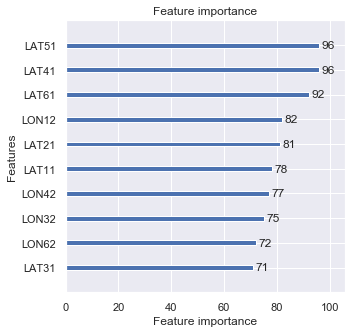

In [372]:
lgb.plot_importance(gbm, max_num_features=10)

In [390]:
df_reg

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,49.234300,49.234300,49.234300,49.234300,0.071426,-14.636884,-0.246545,-8.854571e+01,-8.854571e+01,-8.854571e+01,...,95.185828,95.185828,95.185828,4.091177,165.226742,165.226742,-0.273951,-0.253460,-0.253460,-0.253460
1,19.392771,19.392771,19.392771,19.392771,-0.197070,-4.210995,-1.285319,-8.166486e+01,-8.166486e+01,-8.166486e+01,...,149.062673,149.062673,149.062673,13.021031,338.831483,338.831483,-0.103479,8.165459,8.165459,8.165459
2,-1.861791,-1.861791,-1.861791,-1.861791,17.006937,-23.424765,1.045495,3.430599e-02,3.430599e-02,3.430599e-02,...,-23.044601,-23.044601,-23.044601,-9.478504,-4.462135,-4.462135,-0.122824,-1.976842,-1.976842,-1.976842
3,-6.200260,-6.200260,-6.200260,-6.200260,-1.143269,-19.740936,2.051011,1.013008e+00,1.013008e+00,1.013008e+00,...,-154.658151,-154.658151,-154.658151,2.262552,-9.900988,-9.900988,-0.098238,-7.589132,-7.589132,-7.589132
4,1.548673,1.548673,1.548673,1.548673,-5.745367,13.842989,1.145105,-8.182599e+00,-8.182599e+00,-8.182599e+00,...,-74.645833,-74.645833,-74.645833,-26.459150,3.016904,3.016904,-0.099046,-0.758094,-0.758094,-0.758094
5,0.562264,0.562264,0.562264,0.562264,-7.138208,6.581990,-2.497657,-6.383322e+00,-6.383322e+00,-6.383322e+00,...,92.464809,92.464809,92.464809,-4.086170,3.339697,3.339697,0.045693,2.079498,2.079498,2.079498
6,3.061217,3.061217,3.061217,3.061217,-16.891152,-6.904133,-1.570539,-2.317041e+00,-2.317041e+00,-2.317041e+00,...,319.202811,319.202811,319.202811,5.346434,9.345401,9.345401,-0.090685,-15.492792,-15.492792,-15.492792
7,3.737941,3.737941,3.737941,3.737941,-4.574778,0.441564,-0.075688,-3.073362e+00,-3.073362e+00,-3.073362e+00,...,178.883289,178.883289,178.883289,1.568636,9.703090,9.703090,-0.158832,-4.818701,-4.818701,-4.818701
8,-1.546982,-1.546982,-1.546982,-1.546982,12.107809,7.361617,-0.099701,6.867285e+11,6.867285e+11,6.867285e+11,...,140.823373,140.823373,140.823373,54.356412,-30.214033,-30.214033,-0.098864,1.301514,1.301514,1.301514
9,0.087151,0.087151,0.087151,0.087151,1.891402,1.594652,1.668731,4.287056e+11,4.287056e+11,4.287056e+11,...,171.440883,171.440883,171.440883,29.667071,-34.951093,-34.951093,-0.013160,7.497807,7.497807,7.497807


In [391]:
a = pd.DataFrame({'columns':train_x.columns, 'mean':np.mean(df_xg, axis=1)})

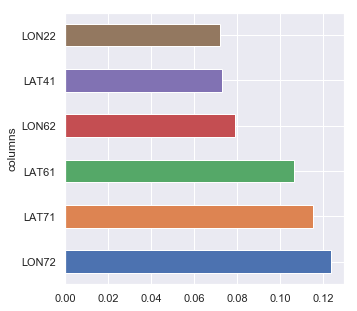

In [409]:
feat_importances = pd.Series(a['mean'].tolist(), index=a['columns'])
feat_importances.nlargest(6).plot(kind='barh')

In [393]:
a = pd.DataFrame({'columns':train_x.columns, 'mean':np.mean(df_rf, axis=1)})

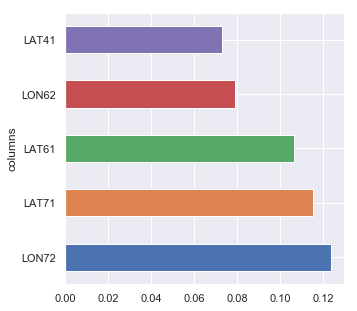

In [410]:
feat_importances = pd.Series(a['mean'].tolist(), index=a['columns'])
feat_importances.nlargest(5).plot(kind='barh')

In [395]:
df_reg.index = train_x.columns
df_reg

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LAT11,49.234300,49.234300,49.234300,49.234300,0.071426,-14.636884,-0.246545,-8.854571e+01,-8.854571e+01,-8.854571e+01,...,95.185828,95.185828,95.185828,4.091177,165.226742,165.226742,-0.273951,-0.253460,-0.253460,-0.253460
LON12,19.392771,19.392771,19.392771,19.392771,-0.197070,-4.210995,-1.285319,-8.166486e+01,-8.166486e+01,-8.166486e+01,...,149.062673,149.062673,149.062673,13.021031,338.831483,338.831483,-0.103479,8.165459,8.165459,8.165459
LAT21,-1.861791,-1.861791,-1.861791,-1.861791,17.006937,-23.424765,1.045495,3.430599e-02,3.430599e-02,3.430599e-02,...,-23.044601,-23.044601,-23.044601,-9.478504,-4.462135,-4.462135,-0.122824,-1.976842,-1.976842,-1.976842
LON22,-6.200260,-6.200260,-6.200260,-6.200260,-1.143269,-19.740936,2.051011,1.013008e+00,1.013008e+00,1.013008e+00,...,-154.658151,-154.658151,-154.658151,2.262552,-9.900988,-9.900988,-0.098238,-7.589132,-7.589132,-7.589132
LAT31,1.548673,1.548673,1.548673,1.548673,-5.745367,13.842989,1.145105,-8.182599e+00,-8.182599e+00,-8.182599e+00,...,-74.645833,-74.645833,-74.645833,-26.459150,3.016904,3.016904,-0.099046,-0.758094,-0.758094,-0.758094
LON32,0.562264,0.562264,0.562264,0.562264,-7.138208,6.581990,-2.497657,-6.383322e+00,-6.383322e+00,-6.383322e+00,...,92.464809,92.464809,92.464809,-4.086170,3.339697,3.339697,0.045693,2.079498,2.079498,2.079498
LAT41,3.061217,3.061217,3.061217,3.061217,-16.891152,-6.904133,-1.570539,-2.317041e+00,-2.317041e+00,-2.317041e+00,...,319.202811,319.202811,319.202811,5.346434,9.345401,9.345401,-0.090685,-15.492792,-15.492792,-15.492792
LON42,3.737941,3.737941,3.737941,3.737941,-4.574778,0.441564,-0.075688,-3.073362e+00,-3.073362e+00,-3.073362e+00,...,178.883289,178.883289,178.883289,1.568636,9.703090,9.703090,-0.158832,-4.818701,-4.818701,-4.818701
LAT51,-1.546982,-1.546982,-1.546982,-1.546982,12.107809,7.361617,-0.099701,6.867285e+11,6.867285e+11,6.867285e+11,...,140.823373,140.823373,140.823373,54.356412,-30.214033,-30.214033,-0.098864,1.301514,1.301514,1.301514
LON52,0.087151,0.087151,0.087151,0.087151,1.891402,1.594652,1.668731,4.287056e+11,4.287056e+11,4.287056e+11,...,171.440883,171.440883,171.440883,29.667071,-34.951093,-34.951093,-0.013160,7.497807,7.497807,7.497807


In [396]:
L = []
for i in df_reg.index :
    L.append(i in ['LAT11', 'LAT21', 'LAT31', 'LAT41', 'LAT51', 'LAT61', 'LAT71'])

In [397]:
U=[]
for i in range(len(df_reg[L].columns)):
    U.extend(list(df_reg[L].iloc[:,i:i+1][0]))

In [398]:
U1=[]
for i in U:
    if -10<i<10:
        i=np.sqrt(np.abs(i))
        U1.append(i)

In [399]:
L = []
for i in df_reg.index :
    L.append(i in ['LON12', 'LON22', 'LON32', 'LON42', 'LON52', 'LON62', 'LON72'])

In [400]:
U=[]
for i in range(len(df_reg[L].columns)):
    U.extend(list(df_reg[L].iloc[:,i:i+1][0]))

In [401]:
U2=[]
for i in U:
    if -10<i<10:
        i=np.sqrt(np.abs(i))
        U2.append(i)

In [402]:
L = []
for i in df_reg.index :
    L.append(i in ['arrive_time13', 'arrive_time23', 'arrive_time33', 'arrive_time43', 'arrive_time53'])

In [403]:
U=[]
for i in range(len(df_reg[L].columns)):
    U.extend(list(df_reg[L].iloc[:,i:i+1][0]))

In [404]:
U3=[]
for i in U:
    if -10<i<10:
        i=np.sqrt(np.abs(i))
        U3.append(i)

In [405]:
L = []
for i in df_reg.index :
    L.append(i in ['distance14', 'distance24', 'distance34', 'distance44', 'distance54', 'distance64'])

In [406]:
U=[]
for i in range(len(df_reg[L].columns)):
    U.extend(list(df_reg[L].iloc[:,i:i+1][0]))

In [407]:
U4=[]
for i in U:
    if -10<i<10:
        i=np.sqrt(np.abs(i))
        U4.append(i)

Text(0,0.5,'Density')

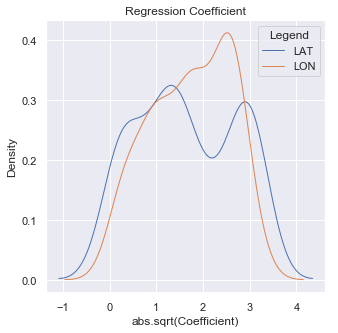

In [408]:
import seaborn as sns    
# Draw the density plot
sns.distplot(U1, hist = False, kde = True,
             kde_kws = {'linewidth': 1}, label = 'LAT')

sns.distplot(U2, hist = False, kde = True,
             kde_kws = {'linewidth': 1}, label = 'LON')

sns.distplot(U3, hist = False, kde = True,
             kde_kws = {'linewidth': 1}, label = 'Arrive_time')

sns.distplot(U4, hist = False, kde = True,
             kde_kws = {'linewidth': 1}, label = 'distance')    

sns.set(rc={'figure.figsize':(5,5)})    

# Plot formatting
plt.legend(title = 'Legend')
plt.title('Regression Coefficient')
plt.xlabel('abs.sqrt(Coefficient)')
plt.ylabel('Density')

In [107]:
a = pd.DataFrame({'columns':train_x.columns, 'mean':np.mean(df_reg, axis=1)})

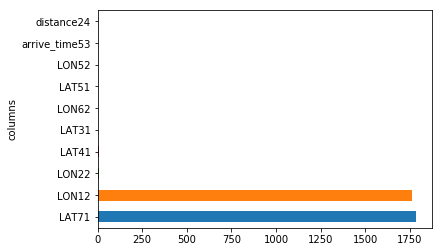

In [108]:
feat_importances = pd.Series(a['mean'].tolist(), index=a['columns'])
feat_importances.nlargest(10).plot(kind='barh')

In [374]:
predict_result_T = predict_result.T
predict_result_T.columns = ['Arrive port', 'MMSI3', 'Cluster', 'Regression', 'Lgbm', 'Xgboost', 'rf']
predict_result_T['Regression'] = predict_result_T['Regression'].apply(lambda x: round(float(str(x).replace(" ", "")[1:5]),2))
predict_result_T['Lgbm'] = predict_result_T['Lgbm'].apply(lambda x: round(float(str(x).replace(" ", "")[1:5]),2))
predict_result_T['Xgboost'] = predict_result_T['Xgboost'].apply(lambda x: round(float(str(x).replace(" ", "")[1:5]),2))
predict_result_T['rf'] = predict_result_T['rf'].apply(lambda x: round(float(str(x).replace(" ", "")[1:5]),2))

In [375]:
predict_result_T.to_csv('D:/SDS_project/data/prediction1.csv', index=False)

In [376]:
predict_result_T

,Arrive port,MMSI3,Cluster,Regression,Lgbm,Xgboost,rf
0,USOAK,255805930_33_1,0022222,0.83,1.39,1.64,0.82
0,USOAK,538004202_35_1,0022222,1.07,0.73,0.73,1.63
0,USOAK,564345000_62_1,0022222,2.12,1.12,-0.00,1.08
0,USOAK,636018189_4_1,0022222,1.40,-0.30,0.12,-3.20
0,USOAK,636091912_41_5,1220222,17.30,-6.00,2.86,-0.20
0,KRPUS,440024000_46_8,0022222,281.00,5.30,7.46,3.46
0,KRPUS,441632000_69_8,0220222,-1.00,3.10,1.93,1.90
0,JPSHS,440337000_33_28,002,8.33,2.41,3.53,3.24
0,JPSHS,441163000_22_28,002,1.27,1.16,1.12,1.02
0,JPSHS,441163000_24_1,002,1.86,1.54,1.30,1.25


# cluster compare

In [ ]:
port_id = 'USOAK'
port_ais = port_5km(data=data, lat=df2.loc[df2.port_id.tolist().index(port_id), 'LAT'], lon=df2.loc[df2.port_id.tolist().index(port_id), 'LON'])
df3 = ten_number(port_ais)
kmeans_clustering(port_ais_data=port_ais, ten_number_data=df3)

In [ ]:
test_cluster = KMeans(n_clusters=6, random_state=0).fit(df3.iloc[:,1:])

In [ ]:
test_cluster1 = pd.concat([df3[0], pd.DataFrame(test_cluster.labels_)], axis=1)
test_cluster1.columns = ['MMSI3', 'Cluster']

In [ ]:
test_cluster1[test_cluster1.Cluster == 0].reset_index(drop=True)

In [ ]:
a = port_ais[port_ais['MMSI3'].apply(lambda x: x in list(test_cluster1[test_cluster1.Cluster == 5].reset_index(drop=True).MMSI3))]

In [ ]:
for i,j in zip(a.LON.tolist(), a.LAT.tolist()):
    plt.plot(i, j, 'rs--', linewidth = 2, markersize = 1)

In [ ]:
num=6
test_cluster = KMeans(n_clusters=num, random_state=0).fit(df3.iloc[:,1:])
test_cluster1 = pd.concat([df3[0], pd.DataFrame(test_cluster.labels_)], axis=1)
test_cluster1.columns = ['MMSI3', 'Cluster']
test_cluster1[test_cluster1.Cluster == 0].reset_index(drop=True)

In [ ]:
cluster_data[cluster_data['Cluster']=='00222222222222']['MMSI3']

In [ ]:
for i in range(0,num):
    a = port_ais[port_ais['MMSI3'].apply(lambda x: x in list(test_cluster1[test_cluster1.Cluster == i].reset_index(drop=True).MMSI3))]
    for i,j in zip(a.LON.tolist(), a.LAT.tolist()):
        plt.plot(i, j, 'rs--', linewidth = 2, markersize = 1)
    plt.show()

In [ ]:
data[data['MMSI3'].isin(cluster_data[cluster_data['Cluster']=='00222222222222']['MMSI3'])].reset_index(drop=True)

In [ ]:
a1 = ten_number(data[data['MMSI3'].isin(cluster_data[cluster_data['Cluster']=='00222222222222']['MMSI3'])].reset_index(drop=True))

In [ ]:
a1 = ten_number(a)

In [ ]:
def mean_test(data):
    mean = data.describe().loc['mean',:]

    L = list()
    for i,j in zip(mean, data.columns):
        sum = 0
        for k in data.index:
            sum = sum + (i-data[j][k])**2
#             sum = sum + abs(i-data[j][k])
        L.append(round(sum,2))
    L1 = np.mean(L)
    
    return round(L1, 2)

In [ ]:
mean = a1.loc[:,1:].describe().loc['mean',:]

In [ ]:
a1

In [ ]:
L = []
L1 = []
for i,j in zip(mean, mean.index):
    sum = 0
    for k in a1.loc[:,1:].index:
        sum = sum + (i-a1.loc[:,1:][j][k])**2
    L.append(round(sum,2))
L1 = np.mean(L)

In [ ]:
L2 = []
for i in a1.iloc[:,1:].index:
    L2.append(np.mean(list((a1.iloc[i,1:]-L)**2)))

In [ ]:
L2

In [ ]:
a1.iloc[L2.index(min(L2)),:]

In [ ]:
for i,j in zip(data[data.MMSI3 =='354362000_51_1'].LON.tolist(), data[data.MMSI3 =='354362000_51_1'].LAT.tolist()):
    plt.plot(i, j, 'rs--', linewidth = 2, markersize = 1)

In [ ]:
m = folium.Map(location=[x.loc[0,'LAT'], x.loc[0,'LON']], zoom_start=1, tiles='Stamen Terrain')
for i in range(1,x.shape[0]):
    folium.CircleMarker(location=[x.loc[i,'LAT'], x.loc[i,'LON']], color = 'red', radius = 1).add_to(m)
m

In [ ]:
data1 = data[data['MMSI3']=='354362000_51_1'].reset_index(drop=True)
m = folium.Map(location=[data1.loc[0,'LAT'], data1.loc[0,'LON']], zoom_start=1, tiles='Stamen Terrain')
for i in range(data1.shape[0]):
    folium.CircleMarker(location=[data1.loc[i,'LAT'], data1.loc[i,'LON']], color = 'red', radius = 1).add_to(m)
m

In [ ]:
# places_on_SAF = pd.read_csv('C:/Users/Lenovo/Downloads/1205_data.csv')
# places_on_SAF = data
# places_on_SAF['ETA4'] = places_on_SAF.ETA.apply(lambda x: x[:10])
# places_on_SAF = pd.concat([places_on_SAF.groupby(['MMSI3','ETA4']).first().reset_index().drop(['ETA4'], axis=1), places_on_SAF.groupby('MMSI3').last().reset_index().drop(['ETA3'], axis=1)]).reset_index(drop=True)
# places_on_SAF = pd.DataFrame(places_on_SAF, columns = ["MMSI3","LAT","LON"])
# places_on_SAF['LON'] = places_on_SAF['LON'].apply(lambda x : (x - 360) if x>0 else x ) 
places_on_SAF = y[y['MMSI3']=='477157700_6_2'].reset_index(drop=True)

a= [] 
for i in range(len(places_on_SAF)) :
     a.append ( tuple( ( places_on_SAF.loc[ i,["LAT","LON" ]])))
places_on_SAF = a
# get the coordinates for these places

lats = [x[0] for x in places_on_SAF]

lons = [x[1] for x in places_on_SAF]

coordinates = zip(lats, lons)
# m = folium.Map(location=[36.5,-122], zoom_start=3, tiles='Stamen Terrain')

# Create the map with the appoximate location of San Andreas Fault

SAF = folium.PolyLine(locations = zip(lats, lons),weight=5,color = 'red')
for each in (zip(lats, lons)):  

    folium.CircleMarker(each, radius = 1.5, color = 'blue').add_to(m)
folium.PolyLine(list(zip(lats, lons)), color="blue", weight=2.5).add_to(m) 
# <folium.vector_layers.PolyLine at 0x1f8e49edda0>
# def get_bearing(p1, p2):


    

#     long_diff = np.radians(p2.lon - p1.lon)

    

#     lat1 = np.radians(p1.lat)

#     lat2 = np.radians(p2.lat)

    

#     x = np.sin(long_diff) * np.cos(lat2)

#     y = (np.cos(lat1) * np.sin(lat2) 

#         - (np.sin(lat1) * np.cos(lat2) 

#         * np.cos(long_diff)))

#     bearing = np.degrees(np.arctan2(x, y))

    

#     # adjusting for compass bearing

#     if bearing < 0:

#         return bearing + 360

#     return bearing
# def get_arrows(locations, color='blue', size=6, n_arrows=len(list(zip(lats,lons)))):

#     Point = namedtuple('Point', field_names=['lat', 'lon'])

    

#     # creating point from our Point named tuple

#     p1 = Point(locations[0][0], locations[0][1])

#     p2 = Point(locations[1][0], locations[1][1])

    

#     # getting the rotation needed for our marker.  

#     # Subtracting 90 to account for the marker's orientation

#     # of due East(get_bearing returns North)

#     rotation = get_bearing(p1, p2) - 90

    

#     # get an evenly space list of lats and lons for our arrows

#     # note that I'm discarding the first and last for aesthetics

#     # as I'm using markers to denote the start and end

#     arrow_lats = np.linspace(p1.lat, p2.lat, n_arrows + 2)[1:n_arrows+1]

#     arrow_lons = np.linspace(p1.lon, p2.lon, n_arrows + 2)[1:n_arrows+1]

    

#     arrows = []

    

#     #creating each "arrow" and appending them to our arrows list

#     for points in zip(arrow_lats, arrow_lons):

#         arrows.append(folium.RegularPolygonMarker(location=points, 

#                       fill_color=color, number_of_sides=3, 

#                       radius=size, rotation=rotation).add_to(m))

#     return arrows
# h = len(places_on_SAF)

 

# for i in range(int(h)-1) :

#     arrows = get_arrows(list(zip(lats, lons))[i:len(places_on_SAF)], n_arrows=1)

#     i + 1

#     for arrow in arrows:

#         arrow.add_to(m)
m

In [132]:
import pandas as pd
import numpy as np
import folium
from sklearn.cluster import KMeans
from math import *
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from collections import namedtuple

In [ ]:
m.save('C:/Users/renz/Downloads/image.html')

In [ ]:
import seaborn as sns                             
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False

data = pd.read_csv('D:/SDS_project/data/prediction.csv') 

plt.figure(figsize = (10,5))   
plt.xticks(rotation = 90)       
plt.plot(data['MMSI3'] , (data['Regression']))                                                                                                                                                                                                       
plt.plot(data['MMSI3'] , (data['Lgbm']))                                                    
plt.plot(data['MMSI3'] , (data['Xgboost'])) 
plt.plot(data['MMSI3'] , (data['Random Forest']))  
plt.xlabel('Cargo Ship',fontsize=20)    
plt.ylabel('Real Time of Arrival - Predicted Time of Arrival',fontsize=16)        
plt.legend(loc='upper right',prop={'size': 6})   